In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional 
from keras.optimizers import RMSprop

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing import sequence

from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import re

import gensim
#from pymystem3 import Mystem
#from stanfordcorenlp import StanfordCoreNLP
import spacy_udpipe

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../task2_data/task2_en_training.tsv',delimiter='\t')
df.head()

,tweet_id,user_id,class,tweet
0,344266386467606528,809439366,0,"depression hurts, cymbalta can help"
1,349220537903489025,323112996,0,"@jessicama20045 right, but cipro can make thin..."
2,351421773079781378,713100330,0,@fibby1123 are you on paxil .. i need help
3,326594278472171520,543113070,0,@redicine the lamotrigine and sjs just made ch...
4,345567138376994816,138795534,0,have decided to skip my #humira shot today. my...


In [3]:
spacy_udpipe.download("en")
nlp = spacy_udpipe.load("en")
model = gensim.models.KeyedVectors.load_word2vec_format("../Embeddings/model.bin", binary=True) 
#model.vocab 

Already downloaded a model for the 'en' language


In [4]:
def lemmatize_with_postag(text = """"Wikipedia is a free online encyclopedia, created and 
                          edited by volunteers around the world.""",
                          nlp=nlp):
    doc = nlp(text)
    tagged = []
    for token in doc:
        lemma = token.lemma_
        pos = token.pos_
        #pos = pos.split('=')[0].strip()
        if pos not in ["PUNCT"]: #["VERB", "NUM", "ADV", "NOUN", "ADJ", "AUX", "PRON", "ADP", "DET", "ADV", "INTJ", "PROPN"]:
            tagged.append(lemma.lower() + '_' + pos)
        #else : print(pos)
    return tagged

In [5]:
X_train = df['tweet']
y_train = df['class']

Xy = pd.concat([X_train, y_train], axis=1)

# paramters of the text praprations
n_items_for_train = 500
n_items_for_test  = 200
max_words         = 2000 

# n_items_for_train твитов для тренировки с индексом класса 1
df_1 = Xy[Xy['class'] == 1].iloc[:n_items_for_train] 
# n_items_for_train твитов для тренировки с индексом класса 0
df_0 = Xy[Xy['class'] == 0].iloc[:n_items_for_train] 

Xy_ = shuffle(pd.concat([df_0, df_1]))
Xy_train = pd.concat([Xy_["tweet"].apply(lemmatize_with_postag), Xy_["class"]], axis = 1)



# n_items_for_test твитов для теста с индексом класса 1
df_1 = Xy[Xy['class'] == 1].iloc[n_items_for_train:n_items_for_train+n_items_for_test]
# n_items_for_test твитов для теста с индексом класса 0
df_0 = Xy[Xy['class'] == 0].iloc[n_items_for_train:n_items_for_train+n_items_for_test]

Xy_ = shuffle(pd.concat([df_0, df_1]))
Xy_test = pd.concat([Xy_["tweet"].apply(lemmatize_with_postag), Xy_["class"]], axis = 1)

print(Xy_train.shape)
print(Xy_test.shape)
#Xy_train, Xy_test

(1000, 2)
(400, 2)


In [6]:
# was replacing in the begining as hyperparameter
#max_words = 3500 # ограничение вокуабуляра

maxima = 0
for ar in Xy_train['tweet'].to_list():
    if len(ar)>maxima: maxima = len(ar)
for ar in Xy_test['tweet']:
    if len(ar)>maxima: maxima = len(ar)
max_len = maxima + 1
print(f'max_len = {max_len}')

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(Xy_train["tweet"]) #fit on train

# exctrax features from train
sequences_train = tok.texts_to_sequences(Xy_train["tweet"])
sequences_matrix_train = sequence.pad_sequences(sequences_train, maxlen=max_len)

# exctrax features from test
sequences_test = tok.texts_to_sequences(Xy_test["tweet"])
sequences_matrix_test = sequence.pad_sequences(sequences_test, maxlen=max_len)

max_len = 36


In [7]:
def fix_word_key(string):
    upper_part = (re.findall('_.*',string))[0].upper()
    result = re.sub(r'_.*', upper_part, string)
    #print(f'was {string} -> became {result}')
    return result

word_index = tok.word_index
#print('Found %s unique tokens' % len(word_index))

wi1 = len(word_index)

# fix tokenizer problem
for key in word_index.keys():
    fixed_key = fix_word_key(key)
    word_index[fixed_key] = word_index.pop(key)
    
#print('Found %s unique tokens' % len(word_index))
wi2 = len(word_index)

if wi1 != wi2:
    print()
    error = 'lenght of word_index was changed!'
    print(error.upper())
    raise ValueError
else:
    print('Everything is OK')
    print(len(word_index))

Everything is OK
4169


In [8]:
# делаем Embedding на основе w2v модели

nb_words = min(max_words, len(word_index))+1 # проверяем где меньше, в нашем датасете или в токенайзере.
EMBEDDING_DIM = 300 # размерность векторов в нашей модели w2v

print(f'number of words = {nb_words}')

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
print(embedding_matrix.shape)

counter = 0
for word, i in word_index.items():
    if i >= nb_words: continue
    if word in model.vocab:
        #print(model[word])
        embedding_matrix[i] = model[word]
#     if counter > nb_words: break
#     counter += 1


print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
#pd.DataFrame(embedding_matrix)

number of words = 2001
(2001, 300)
Null word embeddings: 1170


# BI-LSTM (3.0)

https://stackoverflow.com/questions/44924690/keras-the-difference-between-lstm-dropout-and-lstm-recurrent-dropout

In [17]:
rate_drop_lstm  = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25
act = 'relu'


embedding_layer_fr   = Embedding(nb_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=True) 

embedding_layer      = Embedding(nb_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=False) 

lstm_layer           = Bidirectional(LSTM(64, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))

# CONFIGURATION OF BI-LSTM
sequence_1_input     = Input(shape=(max_len,), dtype='int32')
embedded_sequences_1 = embedding_layer_fr(sequence_1_input)
x1                   = lstm_layer(embedded_sequences_1)

sequence_2_input     = Input(shape=(max_len,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
y1                   = lstm_layer(embedded_sequences_2)

merged               = concatenate([x1, y1])
merged               = Dropout(rate_drop_dense)(merged)
merged               = BatchNormalization()(merged)
merged               = Dense(32, activation=act)(merged)
merged               = Dropout(rate_drop_dense)(merged)
merged               = BatchNormalization()(merged)
preds                = Dense(1, activation='sigmoid')(merged)
#preds                = Dense(2, activation='softmax')(merged)

In [18]:
STAMP = 'lstm_%d_%d_%.2f_%.2f'%(10, 10, rate_drop_lstm, \
        rate_drop_dense)

model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=preds)
model.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc'])
model.summary()
print(STAMP, end='\n\n')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 36)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 36, 300)      600300      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 36, 300)      600300      input_4[0][0]                    
____________________________________________________________________________________________

In [19]:
from myclass import DataGenerator

epochs = 200
batch_size = 32
patience = 10


early_stopping =EarlyStopping(monitor='val_loss', patience=patience)
bst_model_path = STAMP + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

# Parameters
params = {'batch_size': batch_size, #(n_items_for_train, max_len, EMBEDDING_DIM)
          'dim': max_len,
          'n_classes': 1,
          'shuffle': True}

# Datasets
partition_train = sequences_matrix_train
partition_val   = sequences_matrix_test[:n_items_for_test//2]
partition_test  = sequences_matrix_test[n_items_for_test//2:]

labels_train = np.array(Xy_train["class"]).tolist()
labels_val   = np.array(Xy_test["class"]).tolist()[:n_items_for_test//2]

# Train model on dataset
coeff = 1
steps_per_epoch = coeff * (n_items_for_train // batch_size)

# generator of generators
def DEmb_gen(partition_train1, partition_train2, labels_train, params):
    
    genX1 = DataGenerator(partition_train1, labels_train, **params)
    genX2 = DataGenerator(partition_train2, labels_train, **params)
    while 1:
        randy = np.random.randint(len(genX1), size=2)
        X1i = genX1.__getitem__(randy[0])
        X2i = genX2.__getitem__(randy[1])
        yield [X1i[0], X2i[0]], X1i[1]
        
# gg =DEmb_gen(partition_train, partition_train, labels_train, params)
# for i in gg:
#     print(i[1])

In [20]:
# fit model
history = model.fit_generator(generator        =DEmb_gen(partition_train, partition_train, labels_train, params),
                              validation_data  =DEmb_gen(partition_val,   partition_val,   labels_val,   params),
                              validation_steps =5,
                              steps_per_epoch  =steps_per_epoch,
                              
                              use_multiprocessing=True, 
                              workers=2,
                              verbose=2,
                              epochs=epochs, 
                              shuffle=True,
                              callbacks=[early_stopping, model_checkpoint])

/home/alexkay/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/alexkay/anaconda3/lib/python3.7/site-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/200
 - 7s - loss: 0.6970 - acc: 0.6146 - val_loss: 0.6849 - val_acc: 0.7625
Epoch 2/200
 - 2s - loss: 0.6139 - acc: 0.6854 - val_loss: 0.6745 - val_acc: 0.5500
Epoch 3/200
 - 2s - loss: 0.4952 - acc: 0.7729 - val_loss: 0.6802 - val_acc: 0.6375
Epoch 4/200
 - 2s - loss: 0.5264 - acc: 0.7688 - val_loss: 0.6938 - val_acc: 0.5312
Epoch 5/200
 - 2s - loss: 0.3882 - acc: 0.8083 - val_loss: 0.6361 - val_acc: 0.5625
Epoch 6/200
 - 2s - loss: 0.3834 - acc: 0.8208 - val_loss: 0.6258 - val_acc: 0.5625
Epoch 7/200
 - 2s - loss: 0.3688 - acc: 0.8562 - val_loss: 0.6475 - val_acc: 0.7375
Epoch 8/200
 - 2s - loss: 0.2610 - acc: 0.8917 - val_loss: 0.6160 - val_acc: 0.7812
Epoch 9/200
 - 2s - loss: 0.2090 - acc: 0.9146 - val_loss: 0.5568 - val_acc: 0.7812
Epoch 10/200
 - 2s - loss: 0.1763 - acc: 0.9396 - val_loss: 0.5251 - val_acc: 0.7625
Epoch 11/200
 - 2s - loss: 0.1838 - acc: 0.9167 - val_loss: 0.6574 - val_acc: 0.6250
Epoch 12/200
 - 2s - loss: 0.1814 - acc: 0.9333 - val_loss: 0.5035 - val_a

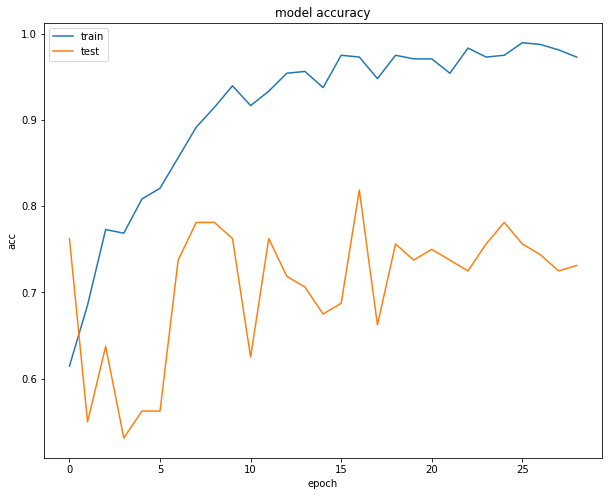

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) 

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [22]:
pred = model.predict([partition_test, partition_test])
pred.shape
bin_pred, real = [], np.array(Xy_test["class"]).tolist()[n_items_for_test//2:]
for i in range(len(pred)):
    #print(f'pred = {int(round(float(pred[i][0]), 0))},\t real = {real[i]}')
    bin_pred.append(int(round(float(pred[i][0]), 0))) 
#np.array(Xy_test["class"]).tolist()
bin_pred, real
from sklearn.metrics import classification_report
print(classification_report(real, bin_pred))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74       153
           1       0.74      0.71      0.72       147

    accuracy                           0.73       300
   macro avg       0.73      0.73      0.73       300
weighted avg       0.73      0.73      0.73       300



In [23]:
pd.DataFrame(confusion_matrix(real, bin_pred), columns=['Pos', 'Neg'])

,Pos,Neg
0,116,37
1,43,104
